# Shapley-Value

In [ ]:
import IPythonImporter
import GameFramework as gf

import copy
import itertools
import numpy as np
import scipy.stats as stats

importing Jupyter notebook from GameFramework.ipynb
importing Jupyter notebook from Shapley.ipynb


In [ ]:
def numberToBase(n, b):
    if n == 0:
        return [0]
    digits = []
    while n:
        digits.append(int(n % b))
        n /= b
    return digits[::-1]

In [ ]:
def splitSkills(scenario):
    struc = np.empty((0,2));  # Skill, Agent
    for agent in scenario.agents:
        for skill in agent.skillCaps:
            struc = np.concatenate((struc, [[str(skill.skill), str(agent._id)] \
                                     for i in range(skill.capacity)]), axis=0)
    return struc


def agentSkills(singleSkills):
    skillDic = {}
    for skill in singleSkills:
        s = tuple(skill)
        if s in skillDic:
            skillDic[s] += 1
        else:
            skillDic.update({s: 1})
            
        agentSkills = []
        for (key, value) in skillDic.items():
             agentSkills.append(list(key) + [value])
                
    return agentSkills

In [ ]:
def buildCoalitions(singleSkills, scenario):
    # Koalitionen codiert als binäre Zahl durchiterieren, 
    bit_digits = singleSkills.shape[0]
    int_number = int(pow(2, bit_digits-1) + pow(2, bit_digits-1)-1)

    coalitionSites = list()
    setCoalitions = set()

    # Jede Koalition bauen und prüfen, welche Baustellen sie bauen können
    for i in xrange(int_number+1):
        bit_string = list(bin(i)[2:].zfill(bit_digits))
        bit_string = np.reshape(np.repeat(bit_string, 2), (bit_digits, 2))
        
        coalition = singleSkills[bit_string=='1']
        coalition = np.reshape(coalition, ((coalition.shape[0]/2, 2)))

        # Check: Kann die Koalition überhaupt Baustellen bedienen?
        if len(coalition) > 0:
            coalitionAgentAggr = agentSkills(coalition)
            strCoalition = str(coalitionAgentAggr)
            
            if strCoalition not in setCoalitions:
                setCoalitions.add(strCoalition)
                coalitionAggr = stats.itemfreq(coalition[:,0])
                possibleSites = list()

                for site in scenario.sites:  # für jede Baustelle
                    if checkCoalitionSite(coalitionAggr, site):
                        possibleSites.append(site._id)
            
                if len(possibleSites) > 0:
                    coalitionSites.append([coalition, possibleSites])
                
    return coalitionSites

In [ ]:
dicCheckCoalitionSite = {}
def checkCoalitionSite(coalitionAggr, site):
    
    abfrage = tuple((str(coalitionAggr), str(site._id)))
    if abfrage in dicCheckCoalitionSite:
        return dicCheckCoalitionSite[abfrage]
    
    valid = True
    for req in site.requests:  # jeden Skill checken
        skillIdx = np.where(coalitionAggr[:,0] == str(req.skill))
        if  coalitionAggr[:,1][skillIdx].shape[0] == 0 or \
            (coalitionAggr[:,1][skillIdx]).astype(int) < req.amount:
            valid = False
            break
            
    dicCheckCoalitionSite.update({abfrage: valid})
    return valid


dicCoalitionAuszahlung = {}
def coalitionAuszahlung(agentSkills, site, scenario):
    
    abfrage = tuple((str(agentSkills), str(site._id)))
    if abfrage in dicCoalitionAuszahlung:
        return dicCoalitionAuszahlung[abfrage]
    
    minCosts = float('inf')
    permutation = list()
    
    for aS in itertools.permutations(agentSkills):
        costs = 0
        perm, belegung  = list(), list()
        requests = copy.deepcopy(site.requests)

        for idx, skill in enumerate(aS):
            agent = scenario.getAgent(skill[1])
            req = [req for req in requests if str(req.skill) == skill[0]][0]
            if req.actAmount > 0:
                req.actAmount -= 1
                belegung.append(site._id)
                costs += agent.getCosts(skill[0], 1, scenario.distance(site, agent))
            else:
                belegung.append("")
                
        
        if costs < minCosts:
            minCosts = costs
            permutation = aS
            
    result = tuple((site.bud-minCosts, permutation, belegung))
    dicCoalitionAuszahlung.update({abfrage: result})
    return result

In [ ]:
def iterateAllSitePosibilities(cs, scenario):
    # jede Verteilung der Skills auf Baustellen ist möglich:
    # #-Baustellen+1 Zustände je Skill möglich:
    # -> geht an keine Baustelle
    # -> geht an Baustelle 0, 1, ...
    bit_digits = len(cs[0])  # Anzahl Skills
    int_number = int(pow(len(cs[1])+1, len(cs[0]))-1)  # (Anzahl Baustellen+1)^(Anzahl Skills)

    # Durchiterieren durch alle Möglicheiten, dabei Matching mit größter Auszahlung speichern
    maxProfit = 0
    maxMatching, maxPerm = list(), list()
                
    for i in xrange(int_number+1):
        number = numberToBase(i, len(cs[1])+1)
        number = (bit_digits-len(number))*[0]+number
                    
        # für jede Baustelle prüfen, ob sie mit den Matching gebaut werden kann
        profit = 0; valid = True
        perm, match= list(), list()
                    
        for site in cs[1]:        
                    
            # Koalition bauen für Baustelle
            coalitionIdx = np.where(np.array(number)==cs[1].index(site)+1)
            coalition = cs[0][coalitionIdx]
                            
            # prüfen, ob Baustelle gebaut werden kann mit der Koalition
            if checkCoalitionSite(stats.itemfreq(coalition[:,0]), scenario.getSite(site)):
                res = coalitionAuszahlung(coalition, scenario.getSite(site), scenario)
                profit += res[0]
                perm.extend(res[1])
                match.extend(res[2])
            else:
                perm.extend(coalition)
                match.extend([""]*len(coalition))
                            
        if profit >= maxProfit:
            maxProfit = profit
            maxMatching = match
            maxPerm = perm
    
    return (maxProfit, np.array(maxPerm), maxMatching)

In [ ]:
def shapley(scenario):
    
    singleSkills = splitSkills(scenario)        # einzelne Skills
    coalitions = buildCoalitions(singleSkills, scenario)  # Koalitionen, die eine Baustelle bauen können
    dicCoalitionAuszahlung = {}  # reset
    dicCheckCoalitionSite = {}  # reset
    
    if len(coalitions) > 0:
        # Auszahlungsbetrag und Matching:
        # auszahlung  -> Auszahlungsbetrag
        # matching[0] -> Baustelle für den ersten Skill in cs[0]
        # matching[1] -> ...              zweiten Skill in cs[0]
        auszahlung = np.zeros(len(coalitions))
        matching = np.empty((len(coalitions), max(len(c[0]) for c in coalitions)), \
                            dtype='|S6')
        
        for idx, cs in enumerate(coalitions):
            if len(cs[1]) < 2:  # nur eine Baustelle möglich
                auszahlung[idx], cs[0], match = coalitionAuszahlung(cs[0], scenario.getSite(cs[1][0]), scenario)
                cs[0] = np.array(cs[0])
                matching[idx, 0:cs[0].shape[0]] = match
                matching[idx, cs[0].shape[0]:]  = ""
            
            else:  # mehrere Baustellen möglich    
                auszahlung[idx], cs[0], match = iterateAllSitePosibilities(cs, scenario)
                matching[idx] = match+[""]*(len(matching[idx])-len(cs[0]))
        
        # Dictionary mit allen Koalitionen mit zugehöriger Auszahlung
        dicAuszahlung = {}
        for cIdx, coa in enumerate(coalitions):
            co = coa[0].sort(axis=0, kind="mergesort")
            dicAuszahlung.update({str(co): auszahlung[cIdx]})
        
        # Dictionary mit allen Agenten
        count = 0
        dicAgents = {}
        for agent in scenario.agents:
            dicAgents.update({agent._id: 0})
            
        for cPerm in itertools.permutations(singleSkills):
            count+=1
            
            # Koalition Skill für Skill aufbauen
            coalBuild = list()
            utilBefore = 0
            for elem in cPerm:
                
                # neuen Skill hinzufügen und Auszahlung bestimmen
                coalBuild.append(elem)
                coa = np.array(coalBuild).sort(axis=0, kind="mergesort")
                if str(coa) in dicAuszahlung:
                    util = dicAuszahlung[str(coa)]
                else:
                    util = 0
                
                # marginalen Beitrag betrachten
                marg = util-utilBefore
                if marg > 0:
                    dicAgents[elem[1]] += marg
                    utilBefore = util
                    
        for key in dicAgents:
            dicAgents[key] /= count
            

        return dicAgents
    return None

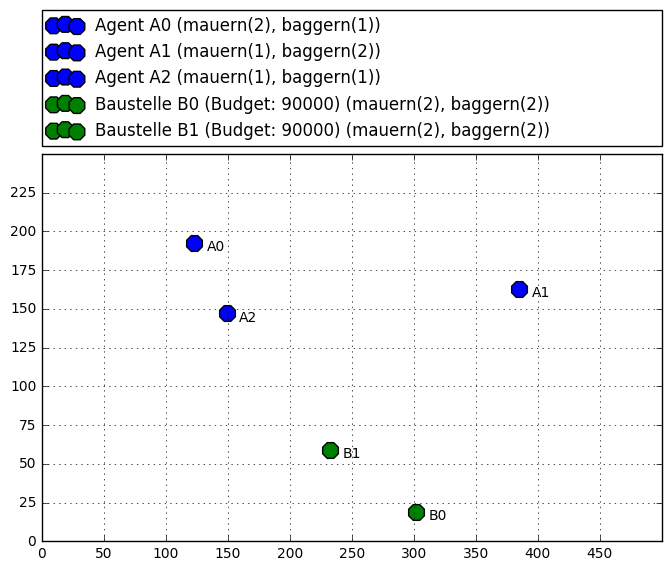

Auszahlungen:
153015.0
[  77646.   76365.   77646.   77887.   76606.   77887.   76606.   77887.
   77887.   76606.   77887.   76606.   77887.   75325.   76606.   76606.
   77887.   78128.   76847.   78128.   76847.   78128.   76847.   78128.
   75566.   76847.   76847.   78128.   75566.   76847.   76847.   78128.
   76847.   77887.   75566.   76847.   76606.   77887.   76847.   77887.
   75566.   76847.   76606.   77887.   77088.   78128.   75807.   77088.
   76847.   78128.   75807.   77088.   76847.   78128.   77088.   78128.
   75807.   77088.   76847.   78128.   75807.   77088.   76847.  153015.]
{'A1': 57380.625, 'A0': 57380.625, 'A2': 38253.75}


In [8]:
'''
scenario = gf.Scenario( agentCount=3, siteCount=2, skills=[gf.Skill("mauern"), gf.Skill("baggern")], \
                        skillCap=[[2,1],[1,2],[1,1]], skillReq=[[2,2],[2,2]], budget=[90000], \
                        costFunction=[['lambda k,d:(k/5+1)*d+20*k', 'lambda k,d:(k/5+1)*d+20*k',\
                                       'lambda k,d:(k/3+1)*d+25*k']] )
scenario.plotMap()
shapley(scenario)
'''

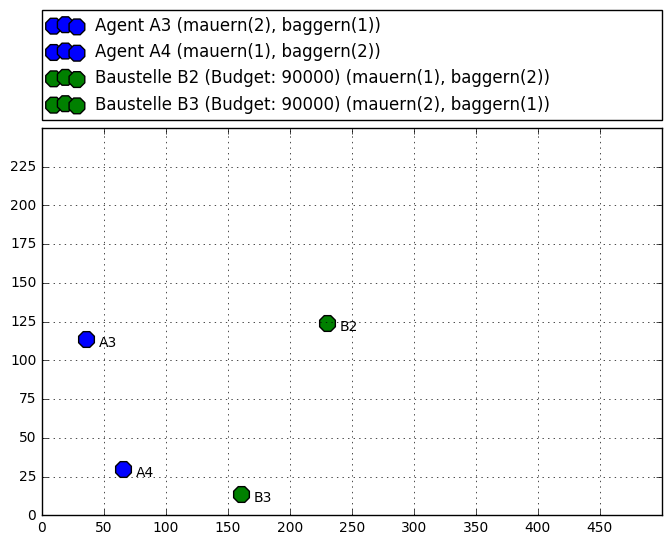

Auszahlungen:
161184.0
[  78504.   78404.   78504.   78404.   82880.   82880.   78304.   78404.
   81595.   82880.   82880.   81595.   81595.   82880.   82880.   80310.
   81595.   81595.   81595.   82880.  161184.]
{'A3': 80592.0, 'A4': 80592.0}


In [9]:
'''
scenario = gf.Scenario( agentCount=2, siteCount=2, skills=[gf.Skill("mauern"), gf.Skill("baggern")], \
                        skillCap=[[2,1],[1,2]], skillReq=[[1,2],[2,1]], budget=[90000], \
                        costFunction=[['lambda k,d:(k/5+1)*d+20*k', 'lambda k,d:(k/5+1)*d+20*k',\
                                       'lambda k,d:(k/3+1)*d+25*k']] )
scenario.plotMap()
shapley(scenario)
'''